# Exploring the Fairness of SAT Tests in New York City

## Introduction
This project looks at data on schools and SAT results in New York City with the lens of whether SATs are fair assessments of academic capability. Spoiler alert: I won't be making any definitive statements here. Whether an established national system for assessing academic capability of high school students is fair (or not) is bound to be a controversial topic, and I certainly do not feel equipped to make any authoritative statements on the subject. However, it will be very interesting to explore how past SAT results vary across schools and districts within the city. I will attempt to extract some meaning from my results using my own personal judgement.

Multiple data files (see below) are cleaned and combined for the purpose of this project.

## Data Source
The data sets for this project come from the [NYC Open Data](https://opendata.cityofnewyork.us/) website. More specifically, each data set has been sourced as follows:
- [2012 SAT Results](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
- [2010 - 2011 School Attendance and Enrollment Statistics by District](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
- [2010-2011 Class Size - School-level detail](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
- [2010 AP (College Board) School Level Results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
- [2005-2010 Graduation Outcomes - School Level](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
- [2006 - 2012 School Demographics and Accountability Snapshot] (https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
- [2011 NYC School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

## Data Cleaning

The data cleaning and combination follows this high level workflow:

1. Reading in .csv data
2. Reading in .txt survey data
3. Adding DBN columns where these are missing in specific DataFrames
4. Converting pertinent columns to numeric data types
5. Condensing data sets
6. Converting AP scores to a numeric data type
7. Combine the DataFrames
8. Adding a column for districts for mapping results

### 1. Read in the data

The first step is to import the .csv files into a dictionary of pandas DataFrames.

In [60]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# import each data set into a dictionary of pandas DataFrames
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### 2. Read in the surveys

The .txt survey data uses a different encoding (windows-1252) and each column is tab rather than comma separated.

In [61]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### 3. Add DBN columns

A `'DBN'` column is added to DataFrames that do not have one, as it will later be used to merge the data into a single DataFrame.

In [62]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### 4. Convert columns to numeric

Average scores for individual SAT sections are converted to numeric types and summed into a new `'sat_column'` column in the `sat_results` DataFrame. School latitude and longitude coordinates are individually extracted into new `'lat'` and `'lon'` columns, respectively, in the `hs_directory` DataFrame.

In [63]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### 5. Condense datasets

- The `class size` data set is condensed to only include high school students in general education programmes, since the focus for examining class sizes is with respect to SAT results. The data is then aggregated on school DBN to provide mean numbers for each column.
- The `demographics` data set is condensed to only include the 2011-2012 school year, since the SAT results data is from 2012.
- The `graduation` data set is condensed to only include the 2006 cohort, the latest data available in the set.

In [64]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### 6. Convert AP scores to numeric

Pertinent `ap_2010` columns are converted to numeric data types.

In [65]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### 7. Combine the datasets

The data sets are merged one-by-one, starting with `sat_results` as it is the primary data set. The `ap_2010` and `graduation` data sets are merged using a 'left' join, to prevent any loss in `sat_results` data; it is not that important if there are `ap_2010` or `graduation` related blanks in the final combined data set. The rest of the data sets are merged using an 'inner' join as it is important to be able to cross compare across these sets of data in the analysis.

In [66]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### 8. Add a school district column for mapping

The final data cleaning step is to add a `'school_dist'` column, which takes the first two characters of the `'DBN'` column. This will allow for aggregating data on school district and mapping results at a digestible level of granularity.

In [67]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analysis

### Find correlations

In [68]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [69]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

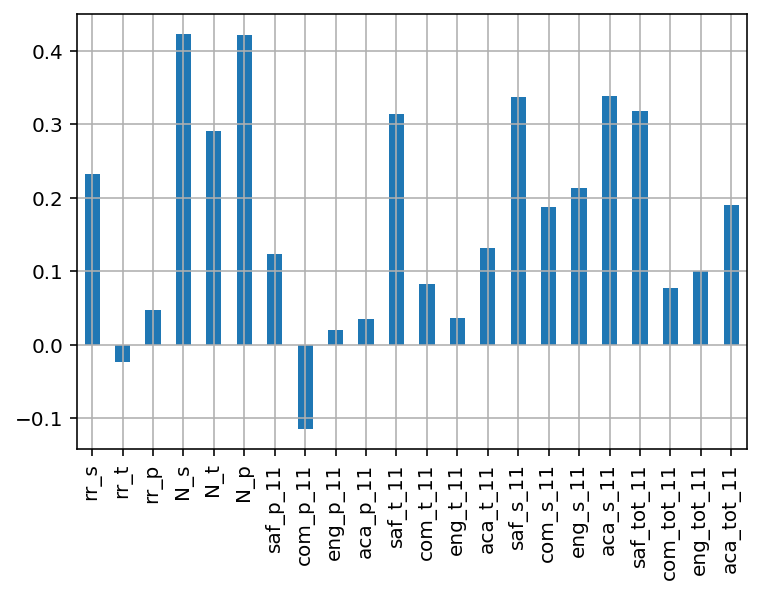

In [70]:
# import and set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

combined.corr().loc[survey_fields, 'sat_score'].plot(kind='bar', grid=True)
plt.show()

Observations on the above plot:

- Parent responses (*_p_* variables) have a very weak correlation with total SAT scores. This suggests that parent opinions on safety and respect, communication, engagement, and academic expectations do not have a strong influence on SAT score outcomes.
- Safety and respect scores from students and teachers have a stronger correlation with SAT results (34% and 31% respectively).
- Academic expectations from student responses also has a stronger correlation with SAT results (34%).
- Numbers of respondents has the strongest correlation with scores - this makes sense since respondent numbers are correlated with total enrollment.

## Investigate Safety Scores

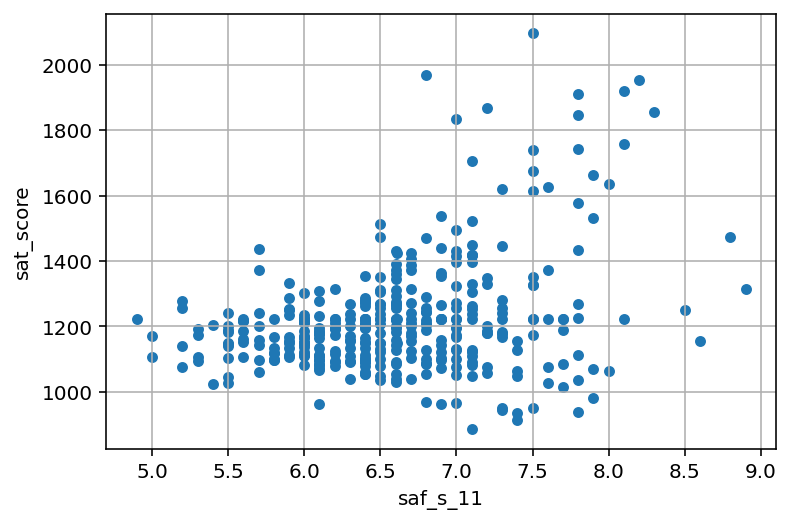

In [71]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score', grid=True)
plt.show()

Investigating the safety scores a little deeper, the above is a scatter plot of student safety scores and average total SAT scores. Most points cluster together, but branch off in two directions at higher safety scores (above 7.0), one of which moves to much higher SAT scores. Schools with a safety score less than about 6.8 from students do not have an average SAT score above around 1500.

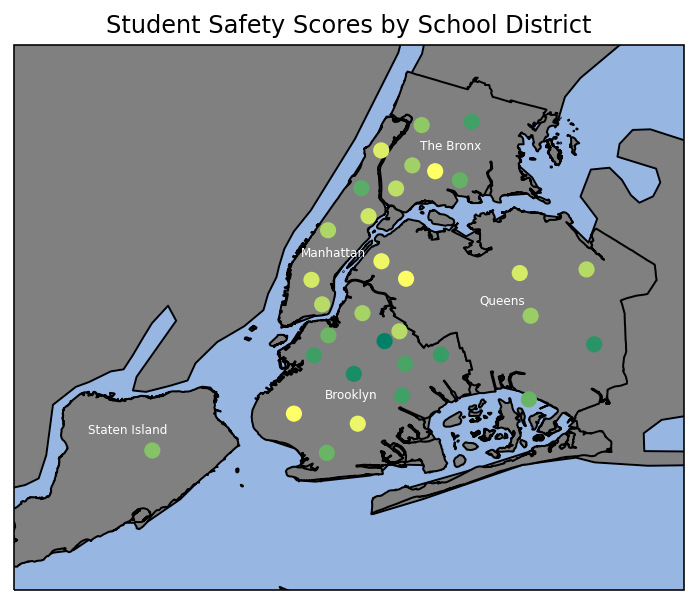

In [135]:
import cartopy.crs as ccrs                      # import projections
import cartopy.feature as cf                    # import features
import cartopy.io.shapereader as shpreader      # import shape file reader

# read in shape data for NYC borough boundaries
reader = shpreader.Reader('Borough Boundaries/geo_export_a04dede4-d79a-4539-9601-dddd0955d2d8.shp')
boroughs = list(reader.geometries())
BOROUGHS = cf.ShapelyFeature(boroughs, ccrs.PlateCarree())

# aggregate combined data on school district
districts = combined.groupby(['school_dist']).agg(numpy.mean)
districts.reset_index(inplace=True)

# set a boundary for plotting the map
nyc_bounds = [
            combined['lon'].min() - 0.05,
            combined['lon'].max() + 0.05,
            combined['lat'].min() - 0.05,
            combined['lat'].max() + 0.05
            ]

# create figure with map background
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(nyc_bounds)
ax.set_title("Student Safety Scores by School District")
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND, facecolor='gray')
ax.add_feature(cf.OCEAN)
ax.add_feature(BOROUGHS, facecolor='gray', edgecolor='black')   # include borough boundaries

# text labels for each of the 5 boroughs
ax.text(x=-74.0, y=40.76, s='Manhattan', fontsize=6, c='white', transform=ccrs.PlateCarree())
ax.text(x=-73.9, y=40.85, s='The Bronx', fontsize=6, c='white', transform=ccrs.PlateCarree())
ax.text(x=-73.85, y=40.72, s='Queens', fontsize=6, c='white', transform=ccrs.PlateCarree())
ax.text(x=-73.98, y=40.64, s='Brooklyn', fontsize=6, c='white', transform=ccrs.PlateCarree())
ax.text(x=-74.18, y=40.61, s='Staten Island', fontsize=6, c='white', transform=ccrs.PlateCarree())

# plot districts on a colour map
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
ax.scatter(longitudes, latitudes, 
           transform=ccrs.PlateCarree(), 
           s=50, zorder=7, 
           c=districts["saf_s_11"], cmap="summer")

plt.show()

The map data for the borough boundaries drawn on the plot above comes from [here](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm).  
  
The Bronx, Manhattan, and north east and south west districts of Brooklyn have higher safety ratings from students. Mid-Brooklyn and Queens have lower safety ratings from students.

## Exploring Race Differences

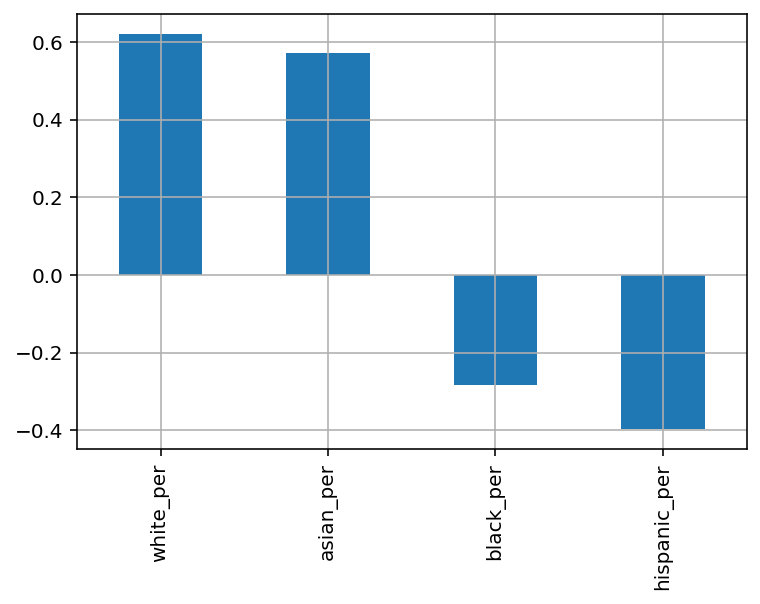

In [74]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr().loc[race_cols, 'sat_score'].plot(kind='bar', grid=True)
plt.show()

There is a reasonably strong positive correlation between proportion of white or Asian students and average SAT score. There is a negative correlation between proportion of black or Hispanic students and average SAT score. This is not unexpected.

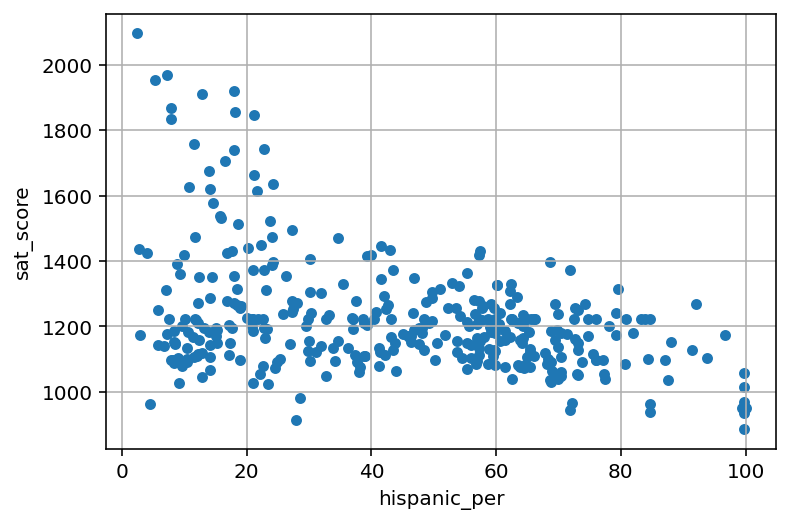

In [75]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score', grid=True)
plt.show()

Interestingly, upon closer investigation, there does not actually appear to be much of a correlation between numbers of Hispanic students and average SAT scores. The overall correlation previously noted is caused by a smaller subset of schools that have very high average SAT scores and happen to also have less than 25% Hispanic students.

In [76]:
print(combined.loc[combined['hispanic_per'] >= 95, 'SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The majority of the schools with >95% Hispanic student population are international schools, which focus on english language learning students.

In [77]:
print(combined.loc[(combined['hispanic_per'] <= 10) & (combined['sat_score'] > 1800), 'SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with <10% Hispanic students and above 1800 average SAT scores focus on STEM subject talent and pre-selection with entrance exams. This explains high average SAT scores, but not the low Hispanic population.

## Exploring Gender Differences

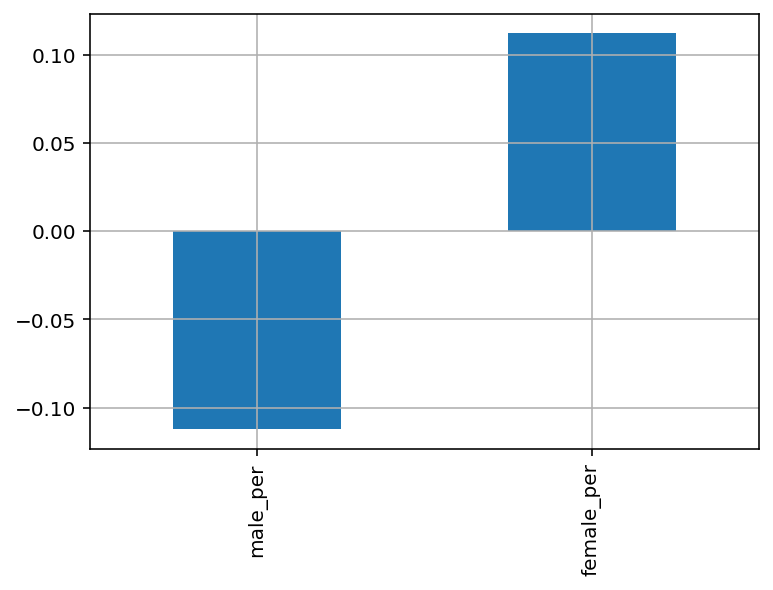

In [78]:
combined.corr().loc[['male_per', 'female_per'], 'sat_score'].plot(kind='bar', grid=True)
plt.show()

There doesn't appear to be an overall correlation between gender and average SAT scores.

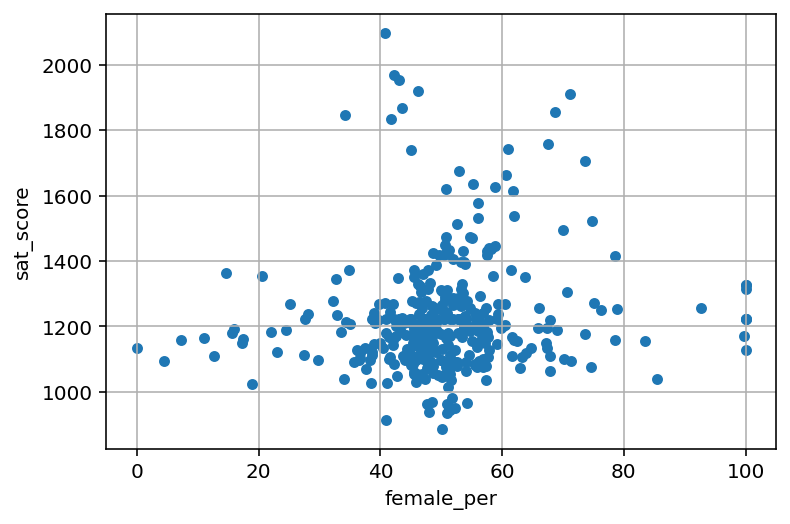

In [79]:
combined.plot(kind='scatter', x='female_per', y='sat_score', grid=True)
plt.show()

There is no distinct correlation between gender and average SAT score. There are a few schools with reasonably balanced gender mixes that happen to have high average SAT scores though.

In [80]:
print(combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700), 'SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be very selective liberal arts schools with high academic standards.

## Exploring AP Test Takers

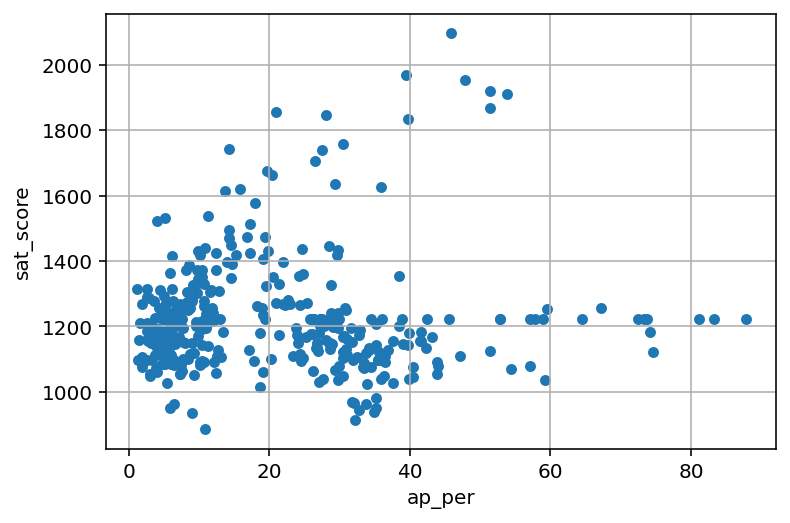

In [81]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100
combined.plot(kind='scatter', x='ap_per', y='sat_score', grid=True)
plt.show()

There appear to be two groups of schools, one with very little correlation between AP test takers and average SAT scores, and another with a rather strong correlation between AP test takers and SAT scores.

## Conclusions